In this notebook, we construct an influence function for the number of clusters. Then, we examine the effect of several functional perturbations to the GMM fit of the iris data. 

In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import paragami

# GMM libraries
import bnpgmm.gmm_clustering_lib as gmm_lib
import bnpgmm.utils_lib as utils_lib
import bnpgmm.gmm_optimization_lib as gmm_optim_lib
from bnpgmm import gmm_posterior_quantities_lib

# BNP libraries
from bnpmodeling.sensitivity_lib import HyperparameterSensitivityLinearApproximation, get_cross_hess
from bnpmodeling import result_loading_utils, influence_lib
from bnpmodeling.bnp_optimization_lib import optimize_kl
import bnpmodeling.functional_sensitivity_lib as func_sens_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/home/rliu/anaconda3/envs/bnp_sensitivity_public/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
iris_obs, iris_species = utils_lib.load_iris_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

The iris data consists of 150 sampled irises; each iris consists of four measurements, 

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

Text(0, 0.5, 'PC2')

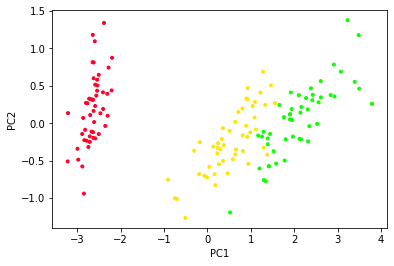

In [3]:
# run pca and plot
pca_fit, pc_iris_obs, colors1, colors2 = utils_lib.get_plotting_data(iris_obs)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

In [5]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

We load the initial fit at $\alpha = \alpha_0$ obtained from `main_parametric_sensitivity.ipynb`. 

Make sure to run that notebook first, which will save the initial model that we re-use here. 

In [6]:
# get vb fit: make sure you've already run  the notebook `main_parametric_sensitivity.ipynb`! 
# That notebook will save `initial_fit.npz`
vb_opt_dict, vb_params_paragami, meta_data = paragami.load_folded('./initial_fit.npz')
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)


# get initial prior parameter alpha 
alpha0 =  meta_data['alpha0'] 
prior_params_dict['dp_prior_alpha'] = alpha0

In [7]:
# checks that the KLs match, so we've loaded the correct model
kl = gmm_lib.get_kl(iris_obs, vb_opt_dict, prior_params_dict, gh_loc, gh_weights)
assert np.abs(meta_data['final_kl'] - kl) < 1e-10

# Define sensitivity class

### this is a class that contains a method to compute and invert the Hessian. 

We will set the perturbation later

In [8]:
def objective_fun(vb_params_free, epsilon): 

    # NOTE! epsilon doesn't actual enter 
    # into this function. 

    # since the initial fit is at epsilon = 0, 
    # we just return the actual KL

    # we will set the perturbation later 

    vb_params_dict = vb_params_paragami.fold(vb_params_free, 
                                             free = True)

    return gmm_lib.get_kl(iris_obs, 
                          vb_params_dict,
                          prior_params_dict,
                          gh_loc,
                          gh_weights).squeeze()

In [9]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun,
                                                    vb_opt,
                                                    hyper_par_value0 = 0., 
                                                    # the perturbed objective is null for now. 
                                                    # will set appropriately later
                                                    hyper_par_objective_fun = lambda x, y : 0.)

Compiling hessian solver ...
Hessian solver compile time: 34.39sec

Compiling cross hessian...
Cross-hessian compile time: 0.0363085sec

LR sensitivity time: 0.0176296sec



# Compute influence function


In [10]:
# this contains methods to compute the influence function
influence_operator = influence_lib.InfluenceOperator(vb_opt, 
                                                     vb_params_paragami, 
                                                     vb_sens.hessian_solver,
                                                     prior_params_dict['dp_prior_alpha'],
                                                     stick_key = 'stick_params')

### Define the posterior statistic

Here, `g` is the expected number of **in-sample** clusters

In [11]:
prng_key = jax.random.PRNGKey(223)

def _g(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_num_clusters_from_vb_dict(iris_obs,
                                                    vb_params_dict,
                                                    gh_loc, gh_weights,
                                                    threshold = 0,
                                                    n_samples = 10000, 
                                                    prng_key = prng_key)

g = jax.jit(_g)

### Get gradient of posterior statistic

In [12]:
# construct the gradient of g and compile
get_grad_g = jax.jit(jax.jacobian(_g, argnums = 0))
_ = get_grad_g(vb_opt).block_until_ready()

In [13]:
# evaluate the gradient of g at the optimal vb parameters
grad_g = get_grad_g(vb_opt)

### Finally, invert the hessian and compute the influence

In [14]:
# the grid on which we compute the influence function
logit_v_grid = np.linspace(-8, 8, 1000)

In [15]:
# this is the influence function evaluated at `logit_v_grid`
influence_grid, _ = \
    influence_operator.get_influence(logit_v_grid, 
                                     grad_g, 
                                     weight_by_inv_prior = False)

# plot the influence

Text(0, 0.5, 'Influence')

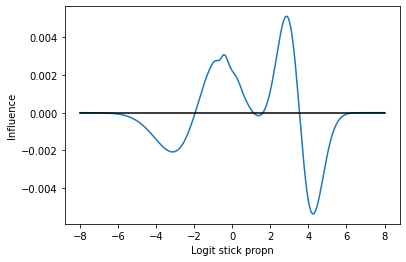

In [16]:
plt.plot(logit_v_grid, influence_grid)

# y = 0 line
plt.plot(logit_v_grid, logit_v_grid * 0., color = 'black')

plt.xlabel('Logit stick propn')
plt.ylabel('Influence')

# Functions to run experiments for different perturbations

In [17]:
def get_lr_derivatives(f_obj, epsilon_vec, fully_linearize = False): 
    
    """
    this function returns the results from our linear approximation. 
    
    f_obj: a class that defines the perturbation
    epsilon_vec: is a vector of epsilons at which we evalute the perturbation. 
        epsilon = 0 is the original prior, epsilon = 1 is the alternative prior. 
    fully_linearize: a boolean; if false, we linearize only the
    
    """
    
    # set derivative 
    vb_sens._set_cross_hess_and_solve(f_obj.hyper_par_objective_fun)
        
    # get lr predictions 
    lr_list = []
    
    if fully_linearize: 
        # this is the derivative of g with respect to the hyper parameter (epsilon)
        dg_dhyper = np.dot(grad_g, vb_sens.dinput_dhyper) 
        lr_g_vec = dg_dhyper * epsilon_vec + g(vb_sens.opt_par_value)
    
    else: 
        for epsilon in epsilon_vec: 
        
            # get linearized variational parameters at epsilon
            lr_free_params = vb_sens.predict_opt_par_from_hyper_par(np.array([epsilon])).block_until_ready()
            
            lr_list.append(lr_free_params)
        
        # evalate g as a function of the variational parameters
        lr_g_vec = result_loading_utils.get_post_stat_vec(g, lr_list)
        
    return lr_g_vec

In [18]:
def get_refit_results(f_obj, epsilon_vec): 
    
    # f_obj contains the perturbation 
    """
    
    this function refits the variational parameters 
    after a perturbation for a range of epsilons. 
    
    f_obj: a class that defines the perturbation
    epsilon_vec: is a vector of epsilons at which we refit the variational parameters. 
    
    """
        
    # define objective 
    def _f(vb_free, epsilon): 
        
        vb_params_dict = vb_params_paragami.fold(vb_free, 
                                                 free = True)

        return gmm_lib.get_kl(iris_obs, 
                              vb_params_dict,
                              prior_params_dict,
                              gh_loc, gh_weights, 
                              e_log_phi = lambda x, y : f_obj.e_log_phi_epsilon(x, y, epsilon))
    
    
    # jit functions and gradients
    f = jax.jit(_f)
    get_grad = jax.jit(jax.grad(_f, 0))
    
    def _get_hvp(x, epsilon, v):
        return jax.jvp(jax.grad(_f, argnums = 0), (x, epsilon), (v, 0.))[1]

    get_hvp = jax.jit(_get_hvp)
    
    # optimize
    vb_refit_list = []
    for epsilon in epsilon_vec: 
        print('\n################')
        print('re-optimzing with epsilon = ', epsilon)
        print('################')

        _, vb_opt_pert, _, _ = \
            optimize_kl(lambda x : f(x, epsilon),
                         deepcopy(vb_opt_dict), 
                         vb_params_paragami, 
                         get_grad = lambda x : get_grad(x, epsilon),
                         get_hvp = lambda x, v: get_hvp(x, epsilon, v),
                         run_lbfgs = False,
                         run_newton = True)                          
        
        vb_refit_list.append(vb_opt_pert)
        
    return vb_refit_list

In [19]:
def run_analysis(f_obj):    
    
    epsilon_vec = np.linspace(0, 1, 6)
    
    ###################
    # get refit results
    ###################
    # get re-fitted vb parameters
    vb_refit_list = get_refit_results(f_obj, epsilon_vec)
    
    # get posterior statistic at re-fitted vb params
    refit_g_vec = result_loading_utils.get_post_stat_vec(g, vb_refit_list)

    ###################
    # get lr results
    ###################
    # posterior statistic with our linear approximation
    lr_g_vec = get_lr_derivatives(f_obj, epsilon_vec, False)
        
    return refit_g_vec, lr_g_vec, epsilon_vec

In [20]:
def plot_results(refit_g_vec, lr_g_vec, epsilon_vec, f_obj): 
    
    ###################
    # plot prior x influence function 
    ###################
    fig, ax = plt.subplots(1, 4, figsize = (14, 3.5))
    
    log_phi_grid = f_obj.log_phi(logit_v_grid)
    
    # scale influence so it has l-inf norm 1
    infl_norm = np.abs(influence_grid).max()
    scale = np.abs(log_phi_grid).max() / infl_norm
    
    ax[0].plot(logit_v_grid, influence_grid * scale,
               label = 'influence')
    # plot y = 0
    ax[0].axhline(0, color = 'black')

    # overlay bump
    ax[0].plot(logit_v_grid, 
               log_phi_grid,
               color = 'grey', 
               label = 'perturbation')

    ax[0].fill_between(logit_v_grid, 
                       0,
                       log_phi_grid,
                       color = 'grey',
                       alpha = 0.5)
    ax[0].legend(loc = 'lower left')
    
    ###################
    # plot perturbed prior 
    ###################
    # compute perturbed prior
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = alpha0,
                                log_phi = f_obj.log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

    prior_perturbation._plot_priors(ax[1])
    prior_perturbation._plot_priors_constrained(ax[2])
    ax[2].legend()

    for j in range(3): 
        ax[j].set_xlabel('logit-sticks')

    ###################
    # plot posterior statistic 
    ###################                        
    # plot refit results
    ax[3].plot(epsilon_vec,
                  refit_g_vec - refit_g_vec[0], 
                  '-o', 
                  label = 'refit')

    # plot lr results
    ax[3].plot(epsilon_vec, 
                  lr_g_vec - lr_g_vec[0], 
                  '-o', 
                  label = 'lr')

    ax[3].set_xlabel('epsilon')
    ax[3].axhline(0, color = 'black')

    ax[3].legend()
    ax[3].set_ylabel('g(pert) - g(init)')

    fig.tight_layout()

In [21]:
def run_all_and_save(f_obj): 
    refit_g_vec, lr_g_vec, epsilon_vec = \
        run_analysis(f_obj)
    
    plot_results(refit_g_vec, lr_g_vec, epsilon_vec, f_obj)

# Get results!

### Gaussian perturbations

Let $\tilde \nu_k$ be the logit stick-breaking proportions, and let $p_0$ be the initial prior on $\tilde \nu_k$. 
In our case, $p_0$ is the prior such that $\nu_k = \text{sigmoid}(\tilde \nu_k)$ is distributed as $\text{Beta}(1, \alpha_0)$. 


We perturb $p_0$ multiplicatively, so the perturbed prior is 
\begin{align*}
p_\epsilon(\tilde \nu_{k}) \propto p_0(\tilde \nu_k) \phi(\tilde \nu_k)^\epsilon. 
\end{align*}

For the first three perturbations, we let $\phi$ be a Gaussian p.d.f. with some mean and variance. 

In [22]:
def gaussian_pert(x, loc, scale): 
    return sp.stats.norm.pdf(x, loc, scale) * np.sqrt(2 * np.pi) * scale


################
re-optimzing with epsilon =  0.0
################
compiling objective and derivatives ... 
done. Compile time: 19.261sec
Running trust-ncg ... 
Newton time: 0.002sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.2
################
compiling objective and derivatives ... 
done. Compile time: 0.996sec
Running trust-ncg ... 
Newton time: 0.075sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.4
################
compiling objective and derivatives ... 
done. Compile time: 0.995sec
Running trust-ncg ... 
Newton time: 0.120sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.6
################
compiling objective and derivatives ... 
done. Compile time: 1.168sec
Running trust-ncg ... 
Newton time: 0.097sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with

/home/rliu/anaconda3/envs/bnp_sensitivity_public/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.784903e-07
  warnings.warn(
/home/rliu/anaconda3/envs/bnp_sensitivity_public/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.954449e-07
  warnings.warn(


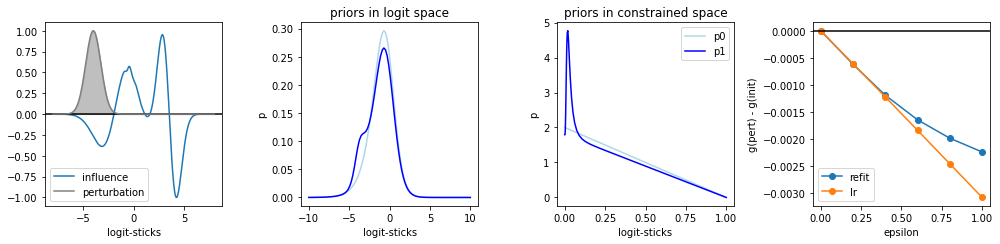

In [23]:
log_phi_gauss1 = lambda x : gaussian_pert(x, loc = -4, scale = 0.75)

f_obj_gauss1 = func_sens_lib.FunctionalPerturbationObjective(log_phi_gauss1, 
                                                          vb_params_paragami, 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'stick_params')

run_all_and_save(f_obj_gauss1)


################
re-optimzing with epsilon =  0.0
################
compiling objective and derivatives ... 
done. Compile time: 18.742sec
Running trust-ncg ... 
Newton time: 0.002sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.2
################
compiling objective and derivatives ... 
done. Compile time: 1.001sec
Running trust-ncg ... 
Newton time: 0.139sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.4
################
compiling objective and derivatives ... 
done. Compile time: 0.999sec
Running trust-ncg ... 
Newton time: 0.120sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.6
################
compiling objective and derivatives ... 
done. Compile time: 1.000sec
Running trust-ncg ... 
Newton time: 0.129sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with

/home/rliu/anaconda3/envs/bnp_sensitivity_public/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.763920e-05
  warnings.warn(


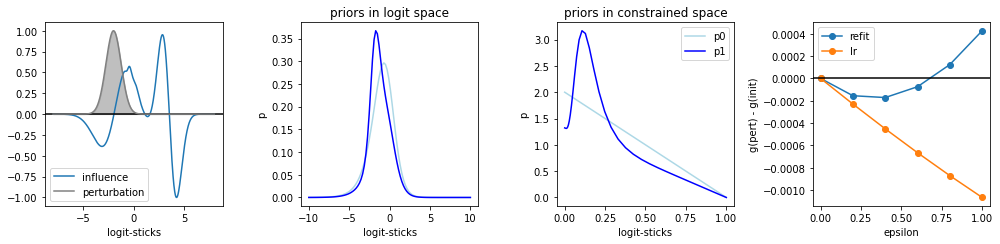

In [24]:
log_phi_gauss2 = lambda x : gaussian_pert(x, loc = -2., scale = 0.75)

f_obj_gauss2 = func_sens_lib.FunctionalPerturbationObjective(log_phi_gauss2, 
                                                          vb_params_paragami, 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'stick_params')

run_all_and_save(f_obj_gauss2)


################
re-optimzing with epsilon =  0.0
################
compiling objective and derivatives ... 
done. Compile time: 18.770sec
Running trust-ncg ... 
Newton time: 0.002sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.2
################
compiling objective and derivatives ... 
done. Compile time: 1.020sec
Running trust-ncg ... 
Newton time: 0.124sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.4
################
compiling objective and derivatives ... 
done. Compile time: 1.021sec
Running trust-ncg ... 
Newton time: 0.158sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.6
################
compiling objective and derivatives ... 
done. Compile time: 1.038sec
Running trust-ncg ... 
Newton time: 0.147sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with

/home/rliu/anaconda3/envs/bnp_sensitivity_public/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.871913e-05
  warnings.warn(


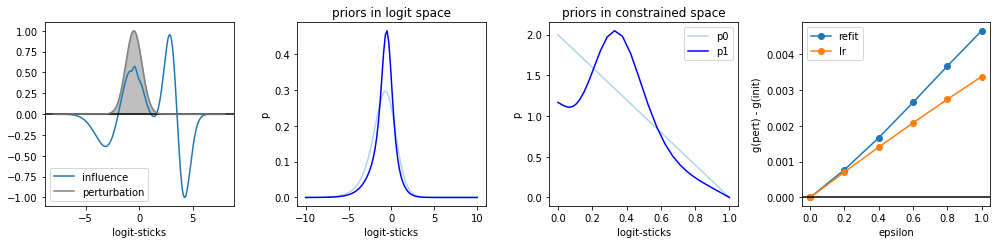

In [25]:
log_phi_gauss3 = lambda x : gaussian_pert(x, loc = -0.5, scale = 0.75) # log_phi_gauss1(x) + log_phi_gauss2(x)

f_obj_gauss3 = func_sens_lib.FunctionalPerturbationObjective(log_phi_gauss3, 
                                                          vb_params_paragami, 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'stick_params')

run_all_and_save(f_obj_gauss3)

### Worst-case perturbation

Finally, we compute results under the worst-case perturbation with L-infinity norm = 1. 

In [26]:
worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                    logit_v_grid = logit_v_grid, 
                                                    delta = 1.,
                                                    cached_influence_grid = influence_grid)

f_obj_wc = func_sens_lib.FunctionalPerturbationObjective(worst_case.log_phi, 
                                                          vb_params_paragami, 
                                                          e_log_phi = lambda x,y : worst_case.get_e_log_linf_perturbation(x,y), 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'stick_params')


################
re-optimzing with epsilon =  0.0
################
compiling objective and derivatives ... 
done. Compile time: 19.729sec
Running trust-ncg ... 
Newton time: 0.002sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.2
################
compiling objective and derivatives ... 
done. Compile time: 1.111sec
Running trust-ncg ... 
Newton time: 0.152sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.4
################
compiling objective and derivatives ... 
done. Compile time: 1.112sec
Running trust-ncg ... 
Newton time: 0.201sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.6
################
compiling objective and derivatives ... 
done. Compile time: 1.113sec
Running trust-ncg ... 
Newton time: 0.224sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with

/home/rliu/anaconda3/envs/bnp_sensitivity_public/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.108081e-03
  warnings.warn(
/home/rliu/anaconda3/envs/bnp_sensitivity_public/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.088925e-01
  warnings.warn(


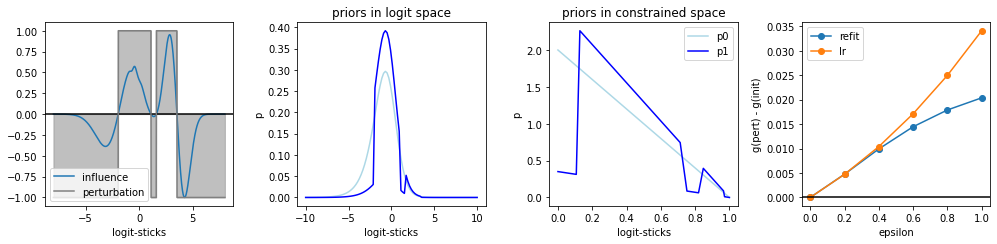

In [27]:
run_all_and_save(f_obj_wc)

In [28]:
plt.legend?